In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 69.8 MB/s 
     |████████████████████████████████| 346 kB 72.5 MB/s 
     |████████████████████████████████| 197 kB 77.8 MB/s 
     |████████████████████████████████| 4.2 MB 44.1 MB/s 
     |████████████████████████████████| 60 kB 9.5 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 55.6 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 140 kB 71.2 MB/s 
     |████████████████████████████████| 212 kB 55.4 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 127 kB 76.8 MB/s 
     |████████████████████████████████| 271 kB 72.9 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 74.8 MB/s 
     |████████████████████████████████| 112 kB 79.5 MB/s 
     |█████████████████

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [ ]:
dsets.train[0]

(fname       005620.jpg
 labels       aeroplane
 is_valid          True
 Name: 2821, dtype: object, fname       005620.jpg
 labels       aeroplane
 is_valid          True
 Name: 2821, dtype: object)

In [4]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

In [ ]:
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/004347.jpg'), ['bird'])

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
idxs = torch.where(dsets.train[100][1]==1)[0]
idxs

TensorMultiCategory([11])

In [ ]:
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
df.index[df['is_valid']]

Int64Index([   0,    1,    2,    4,    6,    7,    8,   10,   12,   18,
            ...
            4992, 4994, 4995, 4997, 5002, 5003, 5005, 5006, 5007, 5008],
           dtype='int64', length=2510)

In [ ]:
df['is_valid']

0        True
1        True
2        True
3       False
4        True
        ...  
5006     True
5007     True
5008     True
5009    False
5010    False
Name: is_valid, Length: 5011, dtype: bool

In [ ]:
~df['is_valid']

0       False
1       False
2       False
3        True
4       False
        ...  
5006    False
5007    False
5008    False
5009     True
5010     True
Name: is_valid, Length: 5011, dtype: bool

In [ ]:
df.index[df['labels']=='aeroplane']

Int64Index([  14,   53,  115,  129,  135,  163,  251,  274,  298,  312,
            ...
            4764, 4786, 4812, 4834, 4842, 4866, 4878, 4957, 4985, 4987],
           dtype='int64', length=200)

In [5]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df).cuda()

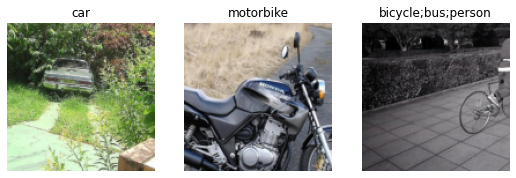

In [15]:
dls.show_batch(nrows=1, ncols=3)

In [23]:
learn = vision_learner(dls, resnet18)
learn.cuda()
x,y = dls.train.one_batch()
x.shape

torch.Size([64, 3, 128, 128])

In [ ]:
x[0]

In [25]:
activs = learn.model(x)

In [26]:
activs.shape

torch.Size([64, 20])

In [27]:
y.shape

torch.Size([64, 20])

In [43]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [45]:
binary_cross_entropy(activs, y)

TensorMultiCategory(1.0972, device='cuda:0', grad_fn=<AliasBackward0>)

In [46]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0972, device='cuda:0', grad_fn=<AliasBackward0>)

In [54]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp > thresh) == targ.bool()).float().mean()

In [56]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.993023,0.747233,0.194203,00:43
1,0.867984,0.577642,0.222968,00:28
2,0.640255,0.219236,0.803028,00:27
3,0.389158,0.143850,0.933626,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.158588,0.129464,0.935020,00:28
1,0.141216,0.122043,0.941992,00:28
2,0.122459,0.119799,0.944363,00:28


In [57]:
preds, targs = learn.get_preds()
preds.shape, targs.shape

(torch.Size([2510, 20]), torch.Size([2510, 20]))

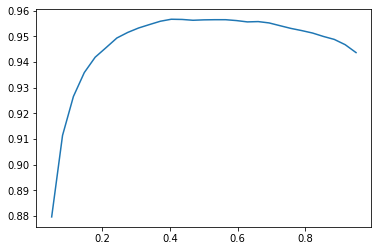

In [58]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)